## Why is modeling helpful?

### 1.

Predictive modeling can show trends and patterns in the number of surgeries scheduled vs the actual number of surgeries performed.

### 2.

Predictive modeling can predict the number of actual surgeries performed on a given day, which can help with resource and staff allocation.

### 3.

With additional data, one can identify factors related to surgeon availability, seasonality, or health trends such as COVID-19 that affect the number of actual surgeries vs number of schedules surgeries; the hospital can thus prepare accordingly.

### 4.

Predictive modeling allows for automatic scheduling of surgeons, patients, nurses, and other important hospital staff around high volume or low volume periods to ensure maximizing resource utilization and minimizing waste.

### 5.

Predictive modeling can be used as a benchmark to see if the hospital's current policies are allowing it to function most efficiently as well as evaluate new changes.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

dat = pd.read_csv('ElectiveSurgeryData.csv')

In [15]:
dat.shape

(241, 19)

In [16]:
dat.columns = dat.columns.str.strip()
dat.head(10)

,SurgDate,DOW,T - 28,T - 21,T - 14,T - 13,T - 12,T - 11,T - 10,T - 9,T - 8,T - 7,T - 6,T - 5,T - 4,T - 3,T - 2,T - 1,Actual
0,10/10/2011,Mon,38,45,60,63,65,70,73,73,73,80,84,89,94,98,100,104,106
1,10/11/2011,Tue,35,47,65,68,78,82,82,82,86,89,92,95,99,99,99,114,121
2,10/12/2011,Wed,26,43,54,62,72,72,72,74,87,94,96,101,102,102,106,114,126
3,10/13/2011,Thu,28,48,65,70,72,72,72,82,87,91,94,94,94,97,98,103,114
4,10/14/2011,Fri,31,40,50,50,50,54,62,68,71,73,73,73,78,83,87,94,106
5,10/17/2011,Mon,41,56,65,69,72,73,77,78,78,80,86,85,86,92,96,102,111
6,10/18/2011,Tue,44,55,69,74,79,83,83,83,93,92,96,103,105,105,107,114,122
7,10/19/2011,Wed,32,40,62,66,71,73,73,84,86,87,89,96,96,96,102,119,127
8,10/20/2011,Thu,33,44,62,66,67,67,79,77,88,90,98,98,98,105,111,118,116
9,10/21/2011,Fri,20,32,48,48,48,47,52,55,59,61,61,61,69,72,70,88,99


### RF

/tmp/ipykernel_355995/2978504476.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dat['Actual'],fit=norm)


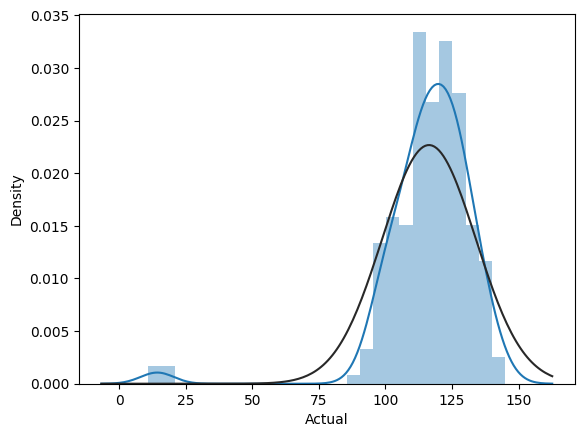

<Figure size 640x480 with 0 Axes>

In [17]:
#histogram and normal probability plot
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.stats import norm
import statistics as stats
import seaborn as sns
import statsmodels.api as sm
sns.distplot(dat['Actual'],fit=norm)
fig = plt.figure()

In [18]:
# These dates have significantly less schedules surgeries due to being holidays.
# We will remove them since they are clearly outliers.
dat.loc[dat['Actual'] < 20]

,SurgDate,DOW,T - 28,T - 21,T - 14,T - 13,T - 12,T - 11,T - 10,T - 9,T - 8,T - 7,T - 6,T - 5,T - 4,T - 3,T - 2,T - 1,Actual
33,11/25/2011,Fri,0,0,1,1,1,1,2,2,2,3,3,3,3,4,7,12,16
53,12/23/2011,Fri,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,14
54,12/26/2011,Mon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,16
58,12/30/2011,Fri,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,6,11


In [19]:
dat = dat.drop(dat[dat['Actual'] < 20].index)
dat.shape

(237, 19)

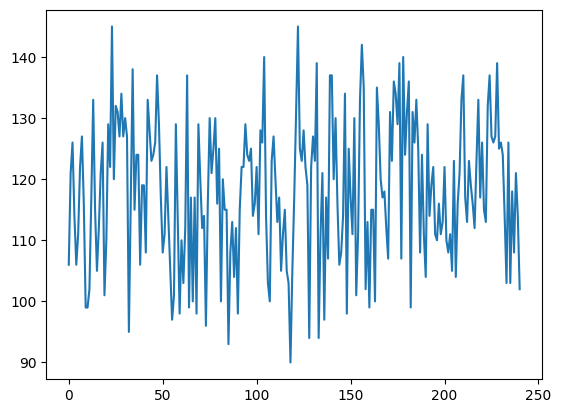

In [20]:
plt.plot(dat["Actual"])

In [21]:
# data is time series, actual of one day could be related to actual of previous day
import datetime as dt
dat['Actual_prev'] = dat['Actual'].shift(1)
dat = dat.dropna()
dat['SurgDate'] = pd.to_datetime(dat['SurgDate']).map(dt.datetime.toordinal)


In [22]:
# One hot encode day of week
one_hot_dat = pd.get_dummies(dat, columns=['DOW'])

In [23]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
X = one_hot_dat.drop(labels = 'Actual', axis = 1)
Y = one_hot_dat['Actual']
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    train_x, test_x = X.iloc[train_index, :], X.iloc[test_index, :]
    train_y, test_y = Y.iloc[train_index], Y.iloc[test_index]

In [29]:
# RF can be used for time series in this case.
# Normally, the rows of time series data are correlated, and will thus lose correlation when we do bootstrapping
# Days of week have been onehot encoded, and there are lagged versions of target variables (previous day actual surgeries).

rf = RandomForestRegressor(n_estimators = 1000, oob_score = True, random_state = 123)
rf.fit(train_x, train_y)
pred = rf.predict(test_x)
# train set out-of-bag error
rf.oob_score_

In [32]:
# test set out-of-bag error
rf2 = RandomForestRegressor(n_estimators = 1000, oob_score = True, random_state = 123)
rf2.fit(test_x, test_y)
rf2.oob_score_

0.7380498919062305

In [41]:
# MAE is a better evaluation metric
# It makes more sense to say on average, how large of an error we can expect
stats.mean(abs(np.array(test_y) - np.array(pred)))

4.3238076923076925

<AxesSubplot:title={'center':'Variable Importance'}>

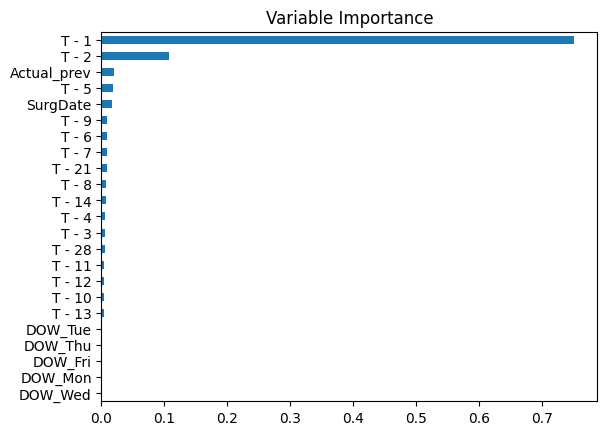

In [48]:
# Variable Importance
importances = rf.feature_importances_
forest_importances = pd.Series(sorted(importances), index=train_x.columns[np.argsort(importances)])
forest_importances.plot(kind = 'barh', title = "Variable Importance")

Text(0.5, 1.0, 'T - 1 and Actual Surgeries have Strong Positive Relationship')

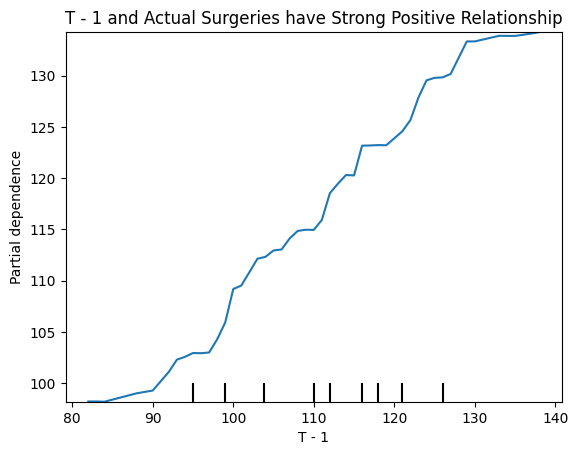

In [66]:
from sklearn.inspection import plot_partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt

# Change the feature_index to the index of the feature you would like to see
# Shows relationship between chosen feature and number of actual surgeries.
feature_index = 16 # T-1
pdp = plot_partial_dependence(rf, train_x, [feature_index], feature_names=rf.feature_names_in_)
pdp.axes_[0][0].set_title("T - 1 and Actual Surgeries have Strong Positive Relationship")


### Barchart

In [27]:
df = dat.groupby(['DOW']).mean().reset_index()[["DOW", "Actual"]]

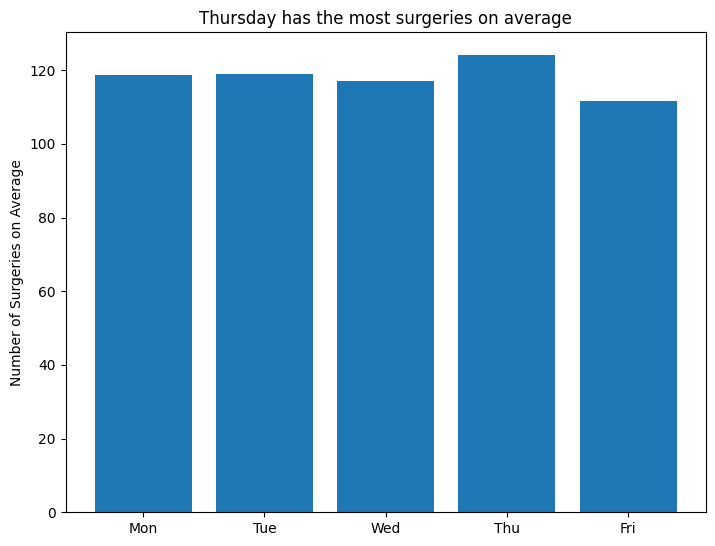

In [28]:
df['key'] = [5,1,4,2,3]
df_sorted = df.sort_values(by = 'key')[['DOW', 'Actual']]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_sorted["DOW"], df_sorted["Actual"])
plt.title('Thursday has the most surgeries on average')
plt.ylabel('Number of Surgeries on Average')
plt.show()

### Important Things to Note About Model

### 1.

The model is a random forest model applied to a regression problem. The upside is that it is robust to outliers and does not easily overfit. Moreover, it can handle high dimensional datasets. This enables future users of the model to add more features (such as variables about hospital staff, etc) to the dataset and still have good performance.

The downside is interpretability suffers. It is more of a black box model and we cannot say for sure how the inputs affect the outputs. We can, however, obtain variable importance and say which feature is more important in predicting the actual amount of surgeries performed.

### 2.

Data must be prepared before it can be fed into the model for prediction. Namely, one must one hot encode the day of week, and one must add a column which records the number of actual surgeries performed in the *previous* day